In [27]:
%matplotlib inline

import pickle, os, sklearn, keras
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import pandas as pd

# Data Importation and test-valid-train split

The problem is to look at Raman spectra of minerals in order to use them to recognize the minerals and possibly quantify their proportions when they are mixed.

In the following cell, we first load the initial, end-member spectra of the 27 minerals selected for this problem.

Then, we also load some manually-created mixtures of up to 3 minerals to train the network to recognize mixtures.

Then train-valid-test splitting of the dataset is done, as well as reshaping for proper entry shape for the 1D CNN network.

In [4]:
#
# Data importation
#
print('Loading data...')


X = np.load('../data/excellent_unoriented/obs.npy')
y = np.load("../data/excellent_unoriented/array_labels.npy")

nb_class = 27
X_synth = np.load('../data/mixed_synthetic/signal_synthetic.npy')
y_synth = np.load('../data/mixed_synthetic/fractions_synthetic.npy')

#
# Train-Test split
#
X_i, X_test, y_i, y_test = train_test_split(np.vstack((X,X_synth)), np.vstack((y,y_synth)), test_size=0.20, random_state=42, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_i, y_i, test_size=0.20, random_state=42, shuffle=True)


#
# Reshaping
# we need to expand to have 3D tensors as input of the 1D CNN

X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print('Shape is {}'.format(X_train.shape))
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')



Loading data...
Shape is (845, 1000, 1)
845 train sequences
265 test sequences


# Building model

For this example we will use a 1D convolutional neural network. See [this post](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf) for instance.

The idea is that the 1D CNN will be sensible to peak shape and relative positions, so that it could be a good predictor for the present multilabel classification problem.

We use Keras and adopt a very simple architecture : 1 conv layer followed by 1 ReLu layer, output is given by a final softmax layer. I tested a sigmoid function in output, as advised in some blogs for multilabel classification, but it performed actually poorly compared to the softmax function.

In [5]:
#%%
print('Build model...')
model = Sequential()

# create the model
model.add(Conv1D(16,8,activation='relu',kernel_initializer='glorot_uniform',input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D())
model.add(Dropout(0.2))

model.add(Conv1D(4,2,activation='relu',kernel_initializer='glorot_uniform'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))

model.add(Dense(nb_class, activation='softmax'))


Build model...


# Initialize model

We use early stopping to prevent overfitting. The loss function is given by the binary crossentropy. I tried a bunch of different loss functions and this seems to be the best performing one for this problem.

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 993, 16)           144       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 496, 16)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 496, 16)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 495, 4)            132       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 247, 4)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 247, 4)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 988)               0         
__________

# Fit

In [8]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=8,callbacks=[early_stopping])

Train on 845 samples, validate on 212 samples
Epoch 1/100
845/845 [==============================] - 4s 5ms/step - loss: 0.1279 - acc: 0.9108 - val_loss: 0.0933 - val_acc: 0.9154
Epoch 2/100
845/845 [==============================] - 2s 2ms/step - loss: 0.0862 - acc: 0.9151 - val_loss: 0.0816 - val_acc: 0.9165
Epoch 3/100
845/845 [==============================] - 2s 2ms/step - loss: 0.0781 - acc: 0.9161 - val_loss: 0.0810 - val_acc: 0.9168
Epoch 4/100
845/845 [==============================] - 2s 2ms/step - loss: 0.0748 - acc: 0.9161 - val_loss: 0.0757 - val_acc: 0.9163
Epoch 5/100
845/845 [==============================] - 2s 2ms/step - loss: 0.0720 - acc: 0.9166 - val_loss: 0.0736 - val_acc: 0.9170
Epoch 6/100
845/845 [==============================] - 2s 3ms/step - loss: 0.0714 - acc: 0.9166 - val_loss: 0.0730 - val_acc: 0.9172
Epoch 7/100
845/845 [==============================] - 2s 2ms/step - loss: 0.0691 - acc: 0.9171 - val_loss: 0.0727 - val_acc: 0.9172
Epoch 8/100
845/845 [==

# Evaluation on test subset

In [9]:
scores_train = model.evaluate(X_train, y_train, verbose=0)
print("Train accuracy: %.2f%%" % (scores_train[1]*100))
scores_valid = model.evaluate(X_valid, y_valid, verbose=0)
print("Valid accuracy: %.2f%%" % (scores_valid[1]*100))
scores_test = model.evaluate(X_test, y_test, verbose=0)
print("TestAccuracy: %.2f%%" % (scores_test[1]*100))

Train accuracy: 91.76%
Valid accuracy: 91.72%
TestAccuracy: 91.78%


# On observations

Those observations are real unknows. We expect single phases as well as mixture.

I select the spectra at position 0 and 3 as I know from petrological observations the answer. Spectrum 0 was acquired on an olivine cristal so its signal should match a 0.9:0.1 mixture of forsterite-fayalite, so classes 10 and 11. Spectrum 3 was acquired on a with-grey area in a sodic granite so its signal should match a mixture of quartz and albite.

First we can see to which minerals the labels correspond to by looking at the excel document

In [29]:
class_correspondance = pd.read_excel("../data/file_liste_excellent.xlsx",sheet_name="subset_to_train")
print(class_correspondance)

         mineral  label
0         Albite      0
1       Ankerite      1
2      Anorthite      2
3      Aragonite      3
4         Augite      4
5      Bytownite      5
6        Calcite      6
7        Diamond      7
8       Diopside      8
9      Enstatite      9
10      Fayalite     10
11    Forsterite     11
12        Gypsum     12
13  Hedenbergite     13
14      Hematite     14
15       Jadeite     15
16      Jarosite     16
17     Kalsilite     17
18   Labradorite     18
19       Leucite     19
20     Magnetite     20
21    Microcline     21
22     Nepheline     22
23    Orthoclase     23
24        Quartz     24
25     Tridymite     25
26        Zircon     26


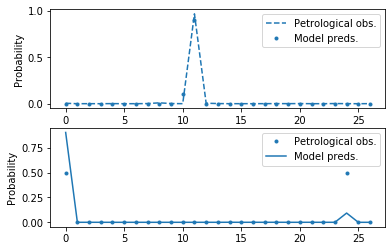

In [38]:
X_observed = np.load("../data/To_Recognize/obs.npy")
X_observed = np.expand_dims(X_observed, axis=2)

prediction_obs = model.predict_proba(X_observed)

plt.figure()
plt.title("Comparison between guess and CNN prediction")
plt.subplot(2,1,1)
plt.plot(prediction_obs[0,:],"--",color="C0",label="Petrological obs.")
plt.plot(np.arange(0,27,1),[0,0,0,0,0,0,0,0,0,0,0.1,0.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],".",color="C0",label="Model preds.")
plt.ylabel("Probability")
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0,27,1),[0.5,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0,0],".",color="C0",label="Petrological obs.")
plt.plot(prediction_obs[3,:],label="Model preds.")
plt.ylabel("Probability")
plt.legend()

# Final comment

We see that the 1D CNN performs well. This method could be interesting to pursue further.